/tmp/ipython-input-240199555.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=role_summary.head(10), y='role_display_name', x='total_inactive', ax=axes[0, 0], palette='Reds_r')
/tmp/ipython-input-240199555.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_time_data, y='role_display_name', x='time_to_activate', ax=axes[0, 1], palette='Blues_r')
/tmp/ipython-input-240199555.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sector_inactive.head(10), x='sector_id', y='inactive_count', ax=axes[1, 0], palette='Greens_

Dashboard saved as 'comprehensive_inactive_analysis.png'

Top 5 Roles by Inactivity:
           role_display_name  total_inactive  time_to_activate
22              Loan Officer             302         46.549296
9        Collections Officer             154         63.811321
8          Collections Agent             127        246.692308
10  Customer Relations Agent              98        242.090909
4             Branch Manager              97         71.656716


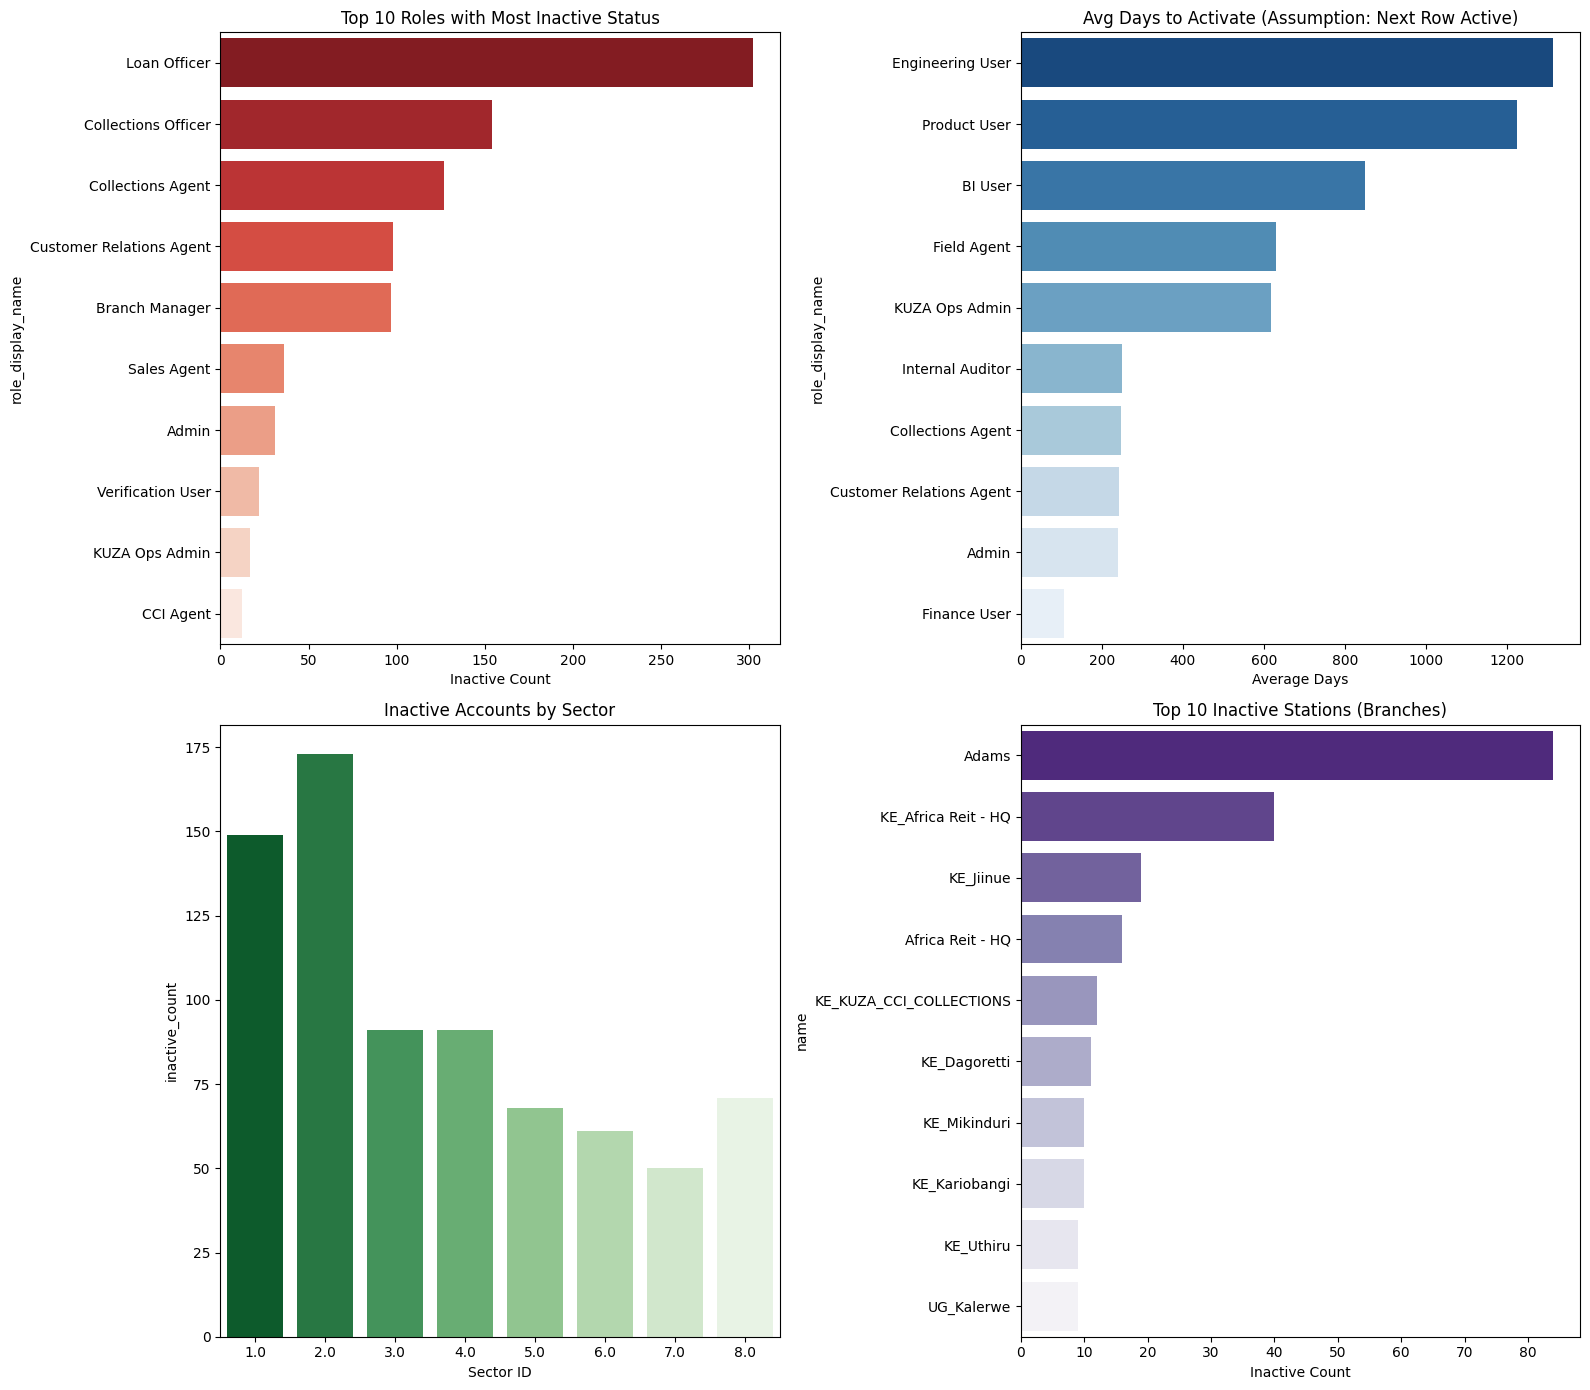

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "Plug in your Data"
df = pd.read_csv(file_path)


df['lastModifiedDate'] = pd.to_datetime(df['lastModifiedDate'], format='ISO8601', utc=True)
df['creationDate'] = pd.to_datetime(df['creationDate'], format='ISO8601', utc=True)

# 2. Time Taken to Activate Calculation
# Assumption: An ACTIVE status record appearing immediately after an INACTIVE record is a reactivation.
# We calculate the time difference between current row and next row.
df['time_to_activate'] = (df['lastModifiedDate'].shift(-1) - df['lastModifiedDate']).dt.total_seconds() / (24 * 3600)

# Identify reactivation events
reactivations = df[(df['userState'] == 'INACTIVE') & (df['userState'].shift(-1) == 'ACTIVE')].copy()

# 3. Role-based Analysis
# Count inactive accounts per role
role_stats = df.groupby('role_display_name').agg(
    total_inactive=('userState', lambda x: (x == 'INACTIVE').sum()),
    total_active=('userState', lambda x: (x == 'ACTIVE').sum())
).reset_index()

# Average time to reactivate by role (using the role of the INACTIVE record)
avg_time_role = reactivations.groupby('role_display_name')['time_to_activate'].mean().reset_index()

# Merge results
role_summary = pd.merge(role_stats, avg_time_role, on='role_display_name', how='left').sort_values('total_inactive', ascending=False)

# 4. Sector and Station (Branch) Inactive Trends
sector_inactive = df[df['userState'] == 'INACTIVE'].groupby('sector_id').size().reset_index(name='inactive_count').sort_values('inactive_count', ascending=False)
station_inactive = df[df['userState'] == 'INACTIVE'].groupby('name').size().reset_index(name='inactive_count').sort_values('inactive_count', ascending=False).head(10)

# 5. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: Roles with most Inactive accounts
sns.barplot(data=role_summary.head(10), y='role_display_name', x='total_inactive', ax=axes[0, 0], palette='Reds_r')
axes[0, 0].set_title('Top 10 Roles with Most Inactive Status')
axes[0, 0].set_xlabel('Inactive Count')

# Plot 2: Average Time to Activate by Role
plot_time_data = role_summary.dropna(subset=['time_to_activate']).sort_values('time_to_activate', ascending=False).head(10)
sns.barplot(data=plot_time_data, y='role_display_name', x='time_to_activate', ax=axes[0, 1], palette='Blues_r')
axes[0, 1].set_title('Avg Days to Activate (Assumption: Next Row Active)')
axes[0, 1].set_xlabel('Average Days')

# Plot 3: Sector Inactivity
sns.barplot(data=sector_inactive.head(10), x='sector_id', y='inactive_count', ax=axes[1, 0], palette='Greens_r')
axes[1, 0].set_title('Inactive Accounts by Sector')
axes[1, 0].set_xlabel('Sector ID')

# Plot 4: Top 10 Inactive Stations (Branches)
sns.barplot(data=station_inactive, y='name', x='inactive_count', ax=axes[1, 1], palette='Purples_r')
axes[1, 1].set_title('Top 10 Inactive Stations (Branches)')
axes[1, 1].set_xlabel('Inactive Count')

plt.tight_layout()
plt.savefig('comprehensive_inactive_analysis.png')
print("Dashboard saved as 'comprehensive_inactive_analysis.png'")

# 6. Save data summaries to CSV
role_summary.to_csv('role_inactivity_summary.csv', index=False)
reactivations[['email', 'role_display_name', 'lastModifiedDate', 'time_to_activate']].to_csv('reactivation_events.csv', index=False)

print("\nTop 5 Roles by Inactivity:")
print(role_summary[['role_display_name', 'total_inactive', 'time_to_activate']].head())